In [1]:
import os
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.metrics import AUC

# Load Data

In [2]:
# Full path is needed
def get_filenames(filepath):
    return [os.path.join(filepath, file) for file in os.listdir(filepath)]

In [3]:
train_dir = os.path.join(os.getcwd(), 'data', 'train_tfrecords')
test_dir = os.path.join(os.getcwd(), 'data', 'test_tfrecords')

train_dataset = tf.data.TFRecordDataset(get_filenames(train_dir))
test_dataset = tf.data.TFRecordDataset(get_filenames(test_dir))

In [4]:
for data in train_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(data.numpy())
    print(example)

features {
  feature {
    key: "CVC - Abnormal"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "CVC - Borderline"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "CVC - Normal"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "ETT - Abnormal"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "ETT - Borderline"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "ETT - Normal"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "NGT - Abnormal"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "NGT - Borderline"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "NGT - Incompletely Imaged"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "NGT - Normal"
    

In [5]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "StudyInstanceUID": tf.io.FixedLenFeature([], tf.string),
        "ETT - Abnormal": tf.io.FixedLenFeature([], tf.int64),
        "ETT - Borderline": tf.io.FixedLenFeature([], tf.int64),
        "ETT - Normal": tf.io.FixedLenFeature([], tf.int64),
        "NGT - Abnormal": tf.io.FixedLenFeature([], tf.int64),
        "NGT - Borderline": tf.io.FixedLenFeature([], tf.int64),
        "NGT - Incompletely Imaged": tf.io.FixedLenFeature([], tf.int64),
        "NGT - Normal": tf.io.FixedLenFeature([], tf.int64),
        "CVC - Abnormal": tf.io.FixedLenFeature([], tf.int64),
        "CVC - Borderline": tf.io.FixedLenFeature([], tf.int64),
        "CVC - Normal": tf.io.FixedLenFeature([], tf.int64),
        "Swan Ganz Catheter Present": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = tf.io.decode_image(example['image'])
    label = [
        tf.cast(example["ETT - Abnormal"], tf.int32),
        tf.cast(example["ETT - Borderline"], tf.int32),
        tf.cast(example["ETT - Normal"], tf.int32),
        tf.cast(example["NGT - Abnormal"], tf.int32),
        tf.cast(example["NGT - Borderline"], tf.int32),
        tf.cast(example["NGT - Incompletely Imaged"], tf.int32),
        tf.cast(example["NGT - Normal"], tf.int32),
        tf.cast(example["CVC - Abnormal"], tf.int32),
        tf.cast(example["CVC - Borderline"], tf.int32),
        tf.cast(example["CVC - Normal"], tf.int32),
        tf.cast(example["Swan Ganz Catheter Present"], tf.int32)
    ]
    return image, label


def read_unlabeled_tfrecord(example):
    FEATURES = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "StudyInstanceUID": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, FEATURES)
    image = tf.io.decode_image(example['image'])
    
    return image

## Data Visulization

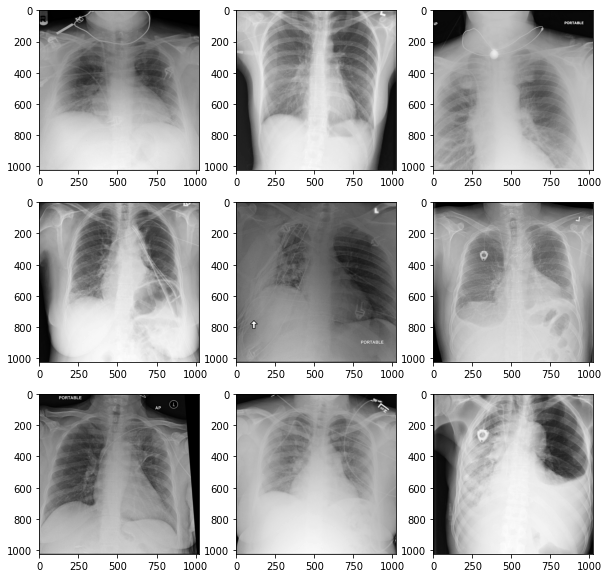

In [6]:
# Train, valid spilit
parsed_train_dataset = train_dataset.map(read_labeled_tfrecord)
train_ds = parsed_train_dataset.skip(4000)
val_ds = parsed_train_dataset.take(4000)

plt.figure(figsize=(10,10))
for i, data in enumerate(train_ds.take(9)):
    img = tf.keras.preprocessing.image.array_to_img(data[0])
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
plt.show()

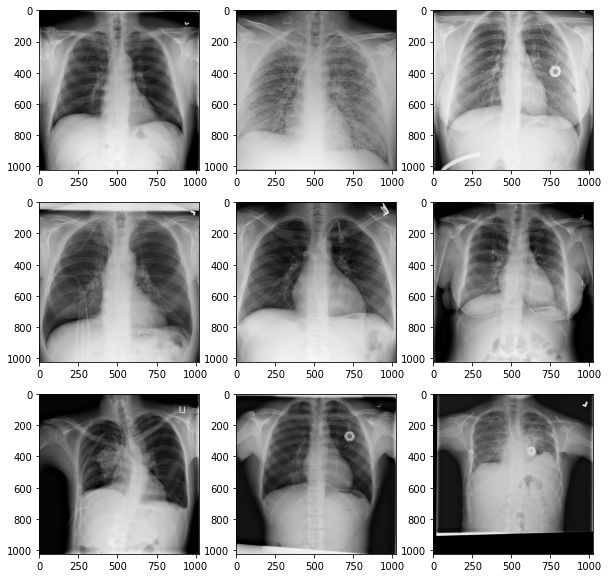

In [7]:
# Test
parsed_test_dataset = test_dataset.map(read_unlabeled_tfrecord)
plt.figure(figsize=(10,10))
for i, data in enumerate(parsed_test_dataset.take(9)):
    img = tf.keras.preprocessing.image.array_to_img(data)
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
plt.show()

# Model

In [7]:
def preprocess_data(self, ds, shuffle=False, augment=False):

    rescale = tf.keras.Sequential(
        [layers.experimental.preprocessing.Rescaling(1. / 255)])

    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    ])

    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y))
    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    # Prefecting on all datasets
    return ds.prefetch(1)

In [8]:
def build_model(pre_trained_model, num_classes):
    """
    Build model with transfer learning
    """
    # Freeze the weights of the pre-trained layers
    for layer in pre_trained_model.layers:
        layer.trainable = False
    # Extract certain layer
    last_layer = pre_trained_model.get_layer('conv5_block15_0_relu')
    last_output = last_layer.output
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(512, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(pre_trained_model.input, x)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=[AUC(multi_label=True)])

    return model


def train_model(model, train_ds, val_ds, save_model=True):
    callbacks = myCallback()
    history = model.fit(train_ds,
                        epochs=100,
                        callbacks=[callbacks],
                        validation_data=val_ds)

    if save_model:
        model.save("Kaggle_cathether_line.h5")
        print(f"Model saved")

    return history


class myCallback(tf.keras.callbacks.Callback):
    """
    Define a Callback class that stops training once accuracy reaches 97.0%
    """
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [11]:
BATCH_SIZE = 32
densenet = DenseNet121(input_shape=(1024, 1024, 3), include_top=False, weights='imagenet')
transfered_model = build_model(densenet, 11)
# Add conv2D to make grey-scale image to fit the input shape
input_tensor = layers.Input(shape=(1024, 1024 ,1))
x = layers.Conv2D(3, (3, 3), padding='same')(input_tensor)
out = transfered_model(x)
model = Model(inputs=input_tensor, outputs=out)

ResourceExhaustedError: OOM when allocating tensor with shape[983040,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

In [22]:
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1024, 1024, 3)     30        
_________________________________________________________________
functional_13 (Functional)   (None, 11)                1013350091
Total params: 1,013,350,121
Trainable params: 1,006,645,289
Non-trainable params: 6,704,832
_________________________________________________________________
